# **Imports**

In [61]:
!pip install datasets
!pip install contractions
!pip install tensorflow
!pip install num2words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [83]:
import os
import pickle
import string
import unicodedata
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from num2words import num2words
import tensorflow as tf
from datasets import load_dataset
import string
import re
import contractions
from contractions import contractions_dict
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Load Dataset**

In [7]:
ds = load_dataset("ccdv/pubmed-summarization", "section")

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

In [8]:
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()
df_val = ds['validation'].to_pandas()

In [9]:
df_train.to_csv('train_dataset.csv', index=False)
df_test.to_csv('test_dataset.csv', index=False)
df_val.to_csv('validation_dataset.csv', index=False)

In [10]:
print(len(df_train['article']), len(df_train['abstract']))
print(len(df_test['article']), len(df_test['abstract']))
print(len(df_val['article']), len(df_val['abstract']))

119924 119924
6658 6658
6633 6633


In [11]:
# Combine the training and validation datasets for processing
df = pd.concat([df_train, df_test, df_val], ignore_index=True)

In [12]:
# Shuffling the df
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 133215


,article,abstract
129386,screw clamping force via application of torque...,purposethe aim of this study was to evaluate t...
99822,parathyroid hormone- ( pth-)related protein ( ...,parathyroid hormone- ( pth- ) related protein ...
23938,obstetrics hemorrhage remains one of the leadi...,key clinical messageearly recognition and acti...
82618,nodular scleroderma is a rare variant of scler...,backgroundnodular scleroderma is a rare varian...
112101,faces are the most complex and frequently enco...,we investigated the developmental aspect of se...


# **Data Preprocessing**

**Null values**

In [15]:
print(df.isnull().sum())

article     0
abstract    0
dtype: int64


**Duplicate values**

In [16]:
print(df.duplicated().sum())
df = df.drop_duplicates()

81


**Data types**

In [17]:
print(df.dtypes)

article     object
abstract    object
dtype: object


**Remove contractions**

In [43]:
def remove_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(map(re.escape, contraction_map.keys()))
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def matched_contractions(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expanded_contraction:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(matched_contractions, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [44]:
# Example contractions dictionary
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [45]:
# Example text
text = "I can't believe it's happening. You're going to love it."

In [46]:
# Expanding contractions
expanded_text = remove_contractions(text, contraction_map=contractions_dict)
print(expanded_text)

I cannot believe it is happening. Youre going to love it.


In [50]:
df['article'] = df['article'].apply(remove_contractions)
df['abstract'] = df['abstract'].apply(remove_contractions)
df.sample(5)

/tmp/ipykernel_33/3442119425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(remove_contractions)
/tmp/ipykernel_33/3442119425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(remove_contractions)


,article,abstract
43674,it is estimated that 26.2% of americans aged 1...,purpose : the purpose of this study is to exam...
53337,ground - nesting insect societies face challen...,flooding impacts ground nesting ant colonies b...
89769,\n addition of a methyl group to the 5th carb...,reduced representation bisulfite sequencing ( ...
47141,women require special need - based health care...,objective : to determine the prevalence of pre...
100068,comparison to sequence and structural neighbor...,"we describe markus , a web server for analysis..."


**Remove punctuations**

In [51]:
def word_punctuation(word):
    clean_alphabet = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet)

def text_punctuation(text):
    clean_word = [word_punctuation(word) for word in text.split()]
    return ' '.join(clean_word)

In [52]:
text = "Hello, world! This is a test."

In [53]:
clean_text = text_punctuation(text)
print(clean_text)

Hello world This is a test


In [54]:
df['article'] = df['article'].apply(text_punctuation)
df['abstract'] = df['abstract'].apply(text_punctuation)
df.sample(5)

/tmp/ipykernel_33/4256673008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(text_punctuation)
/tmp/ipykernel_33/4256673008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(text_punctuation)


,article,abstract
40822,frozen shoulder is one of the prevalent and pa...,background adhesive capsulitis is a common di...
40410,,humic substances the dark colored natural o...
51852,terbium belongs to the rarest elements partic...,backgroundin spite of the fact that terbium is...
55417,the intertidal environment of the marine musse...,the mitochondrion exhibits biochemical and fun...
17483,historically aesthetic facial surgery has bee...,preprosthetic surgeries are generally dealt wi...


**Lowercase**

In [55]:
# Converting to lowercase
df['article'] = df['article'].apply(str.lower)
df['abstract'] = df['abstract'].apply(str.lower)
df.sample(5)

/tmp/ipykernel_33/1506825017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(str.lower)
/tmp/ipykernel_33/1506825017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(str.lower)


,article,abstract
104221,in 1976 slavin et al first described a disti...,a 48year old male presented to our hospital w...
26585,in denmark a nationwide screening program for...,backgroundin denmark a nationwide screening p...
74466,furthermore examination of explanted hearts c...,analysis of the explanted hearts from heart tr...
110283,more than one million of necessitate hemodialy...,purpose we assessed the influences of indivi...
80181,dental caries is a multifactorial infectious a...,backgroundour study aimed to evaluate the effe...


**Remove stopwords**

In [56]:
# Remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [57]:
# Example text
text = "This is a sample sentence demonstrating the removal of stopwords from a text."

In [58]:
# Call the remove_stopwords function
clean_text = remove_stopwords(text)
print("Cleaned text:", clean_text)

Cleaned text: sample sentence demonstrating removal stopwords text.


In [59]:
df['article'] = df['article'].apply(remove_stopwords)
df['abstract'] = df['abstract'].apply(remove_stopwords)
df.sample(5)

/tmp/ipykernel_33/4125015060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(remove_stopwords)
/tmp/ipykernel_33/4125015060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(remove_stopwords)


,article,abstract
126268,respiratory distress continues account signifi...,purpose present study evaluate serum levels et...
64011,accurate diagnosis staging abdominal thoracic ...,background objective navigation flexible endos...
38905,cornea anterior structure eye convex transpare...,corneal ectasia weakening corneal integrity oc...
72034,osteoporosis medical condition defined low bon...,goals recent findings suggest prevalence osteo...
29261,consensus whether antipsychotic benzodiazepine...,32year old man diagnosed catatonic schizophren...


**Number to words**

In [67]:
def num_to_words(text):
    def replace_number(match):
        number = int(match.group())
        try:
            return num2words(number)
        except OverflowError:
            # If the number is too large, return the original number as a string
            return str(number)
    
    return re.sub(r'\b\d+\b', replace_number, text)

In [68]:
# Example text
text = "We are in the year 2024"

In [69]:
# Call the remove_stopwords function
clean_text = num_to_words(text)
print("Cleaned text:", clean_text)

Cleaned text: We are in the year two thousand and twenty-four


In [70]:
df['article'] = df['article'].apply(num_to_words)
df['abstract'] = df['abstract'].apply(num_to_words)
df.sample(5)

/tmp/ipykernel_33/587237651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(num_to_words)
/tmp/ipykernel_33/587237651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(num_to_words)


,article,abstract
106933,ketamine dissociative anesthetic agent n methy...,28year old female 1year history ketamine abuse...
48660,students often choose biology safe refuge insi...,developing connection biology mathematics one ...
128237,nitrogen vacancy centers nvcs diamond great pr...,investigate aerobic oxidation high pressure hi...
8431,stroke statistically ranks third leading cause...,panax ginseng well known economic medical plan...
30419,first recruited group sixty-five type two diab...,objectivechronic renal insufficiency andor pro...


**Remove unnecessary tags/URLs/whitespaces**

In [75]:
# Cleaning text
def preprocess_text(text):
    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing excess whitespace
    text = ' '.join(text.split())

    return text

In [76]:
# Example text
sample_text = """
    <html>
        <body>
            <p>Check out this awesome website: <a href="http://example.com">example.com</a></p>
            <p>    This is an example paragraph with    excessive     whitespace.    </p>
        </body>
    </html>
"""

In [77]:
# Using the preprocess_text function
cleaned_text = preprocess_text(sample_text)
print(cleaned_text)

Check out this awesome website: example.com This is an example paragraph with excessive whitespace.


In [78]:
df['article'] = df['article'].apply(preprocess_text)
df['abstract'] = df['abstract'].apply(preprocess_text)
df.sample(5)

/tmp/ipykernel_33/963278617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].apply(preprocess_text)
/tmp/ipykernel_33/963278617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(preprocess_text)


,article,abstract
126311,blood transfusions play major role resuscitati...,background although blood ordering common prac...
73786,metagenomics analysis microbial community dna ...,deulajhari hot spring located angul district o...
46307,addition synchronous colonic carcinoma lymphom...,colorectal cancer third common malignancy kore...
90927,two popular protein classification schemes cat...,fragnostic web tool implements novel useful vi...
3409,since first laparoscopic hepatectomy lh report...,abstractlaparoscopic major hepatectomy common ...


**Abstract tokenization**

In [79]:
df['abstract'] = df['abstract'].apply(lambda x: f'_START_ {x} _END_')

/tmp/ipykernel_33/2834432185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(lambda x: f'_START_ {x} _END_')


In [80]:
start_token = 'sostok'
end_token = 'eostok'
df['abstract'] = df['abstract'].apply(lambda x: f'{start_token} {x} {end_token}')

/tmp/ipykernel_33/532355019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].apply(lambda x: f'{start_token} {x} {end_token}')


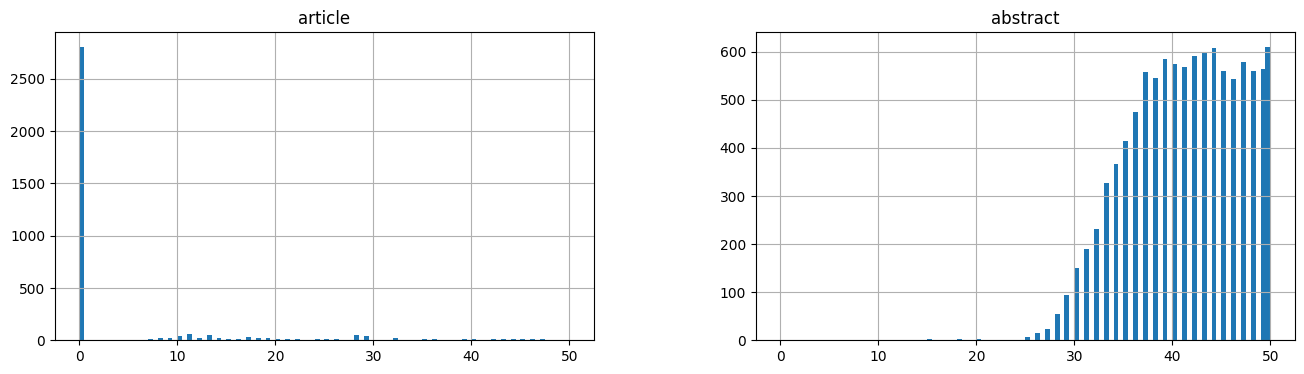

In [84]:
article_count = [len(sentence.split()) for sentence in df.article]
abstract_count = [len(sentence.split()) for sentence in df.abstract]

pd.DataFrame({'article': article_count, 'abstract': abstract_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [90]:
max_article_length = 8000
max_abstract_length = 250

In [91]:
# Select the text between their defined max lengths respectively
def trim_text(df, max_article_length, max_abstract_length):
    cleaned_article = np.array(df['article'])
    cleaned_abstract = np.array(df['abstract'])

    short_article = []
    short_abstract = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_article_length and len(cleaned_abstract[i].split()) <= max_abstract_length:
            short_article.append(cleaned_article[i])
            short_abstract.append(cleaned_abstract[i])

    df = pd.DataFrame({'article': short_article, 'abstract': short_abstract})
    return df


df = trim_text(df, max_article_length, max_abstract_length)
print(f'Dataset size: {len(df)}')

df.sample(5)

Dataset size: 99


,article,abstract
59,administration intravenous tissue plasminogen ...,sostok _START_ backgroundintravenous tissue pl...
21,auditory brainstem response abr noninvasive me...,sostok _START_ background objectivesauditory b...
26,,sostok _START_ adequate cognitive functioning ...
30,ifosfamide induced nephrotoxicity first descri...,sostok _START_ ifosfamide induced fanconi synd...
82,aphids constitute diversified group insects wi...,sostok _START_ since establishment symbiosis a...


In [92]:
# Rare word analysis
def rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [93]:
df.to_csv('df_pp.csv', index=False)

**Dataset splitting**

In [94]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['article']),
    np.array(df['abstract']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenization & padding on article**

In [96]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 63.3, 'total_coverage': 9.45, 'count': 10024, 'total_count': 15836}


In [97]:
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])

In [98]:
# Save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [99]:
# One-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# Padding
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_article_length, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_article_length, padding='post')

x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

5813


**Tokenization & padding on abstract**

In [101]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 89.93, 'total_coverage': 55.26, 'count': 3304, 'total_count': 3674}


In [102]:
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])

In [103]:
# Save tokenizer
with open('y_tokenizer2', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
# One-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# Padding
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_abstract_length, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_abstract_length, padding='post')

y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

371


In [105]:
# Removing abstract which only has sostok & eostok
def remove_indexes(abstract_array):
    remove_indexes = []
    for i in range(len(abstract_array)):
        count = 0
        for j in abstract_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

# **Data Modelling**

In [107]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50